In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.utils.tensorboard import SummaryWriter
plt.style.use('fivethirtyeight')

class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform_x=None, transform_y=None):
        self.x = x
        self.y = y
        self.transform_x = transform_x
        self.transform_y = transform_y
    
    def __getitem__(self,index):
        x = self.x[index]
        y = self.y[index]
        if self.transform_x:
            x = self.transform_x(x)
        if self.transform_y:
            y = self.transform_y(y)
            
        return x, y
    
    def __len__(self):
        return len(self.x)
    


def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

def mini_batch(device, data_loader, step):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mini_batch_loss = step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
        loss = np.mean(mini_batch_losses)
    return loss

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False    
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class Rescale(object):
    
    def __init__(self, value):
        assert isinstance(value, (float, tuple))
        self.value = value
    
    def __call__(self,sample):
        return sample/self.value

class Inverse_Rescale(object):
    
    def __init__(self, value):
        assert isinstance(value, (float, tuple))
        self.value = value
    
    def __call__(self,sample):
        return sample*self.value

class Standardize(object):
    
    def __init__(self, std, mean):
        self.std = std
        self.mean = mean
        
    def __call__(self,sample):
        return ( sample - self.mean)/self.std
        
class Inverse_Standardize(object):
    def __init__(self, std, mean):
        self.std = std
        self.mean = mean
        
    def __call__(self,sample):
        return ( sample*self.std + self.mean)

class FES_NN(nn.Module):
    
    def __init__(self, num_features, outputs, layers):
        super(FES_NN, self).__init__()
        self.hidden = nn.ModuleList()
        for id, layer in enumerate(layers):
            if id == 0:
                self.hidden.append(nn.Linear(num_features,layer))
            else:
                self.hidden.append(nn.Linear(layers[id-1],layer))
        self.out = nn.Linear(layers[-1],outputs)
        
        self.act_fn = nn.ReLU()
        
    def forward(self, x):
        for layer in self.hidden:
            x = self.act_fn(layer(x))
        out = self.out(x)
        return out
    
    def predict(self, x):
        for layer in self.hidden:
            x = self.act_fn(layer(x))
        out = self.out(x)
        return out

class FES_Model(object):
    """
        Documentation for the FES_ML class.
    """
    def __init__(self, model, loss_fn, optimizer):       
        self.reset(model, loss_fn, optimizer)
        
        
    def reset(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        # Determine if using GPU or not
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
        self.to(self.device)
        
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        self.losses = []
        self.val_losses = [] 
        self.total_epochs = 0
        
        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()       
                
    def to(self, device):
        # If user wants to send model to a specific device
        self.device = device
        self.model.to(self.device)
                          
    def set_data_loaders(self, train_loader, val_loader=None):

        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

    def _make_train_step(self):
        
        def next_train_step(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y.unsqueeze(1))
            # Compute gradients
            loss.backward()
            self.optimizer.step()
            # Reset gradients
            self.optimizer.zero_grad()
            return loss.item()
        
        return next_train_step
    
    def _make_val_step(self):
        
        def next_val_step(x,y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat,y.unsqueeze(1)) 
            return loss.item()
        
        return next_val_step
    
    def _mini_batch(self, validation=False):

        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step
            
        if data_loader is None:
            return None
        
        
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:       
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
        
        loss = np.mean(mini_batch_losses)
        return loss
    
    def set_seed(self, seed = 42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        
        self.set_seed(seed)
        for epoch in range(n_epochs):
            self.total_epochs += 1
            
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
            
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                self.writer.add_scalars(main_tag='loss',tag_scalar_dict=scalars,global_step=epoch)
        
        if self.writer:
            self.writer.close()
            
    def save_checkpoint(self, filename):
        checkpoint = {'epoch': self.total_epochs,
              'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'loss': self.losses,
              'val_loss': self.val_losses}
        
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)
        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.model.train() # always use TRAIN for resuming training  

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()
    
    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)



In [51]:
data = np.genfromtxt("ML.dat")
print(data.shape)


columns = []
for i in range(data.shape[1]//2):
    columns.append(str('Phi-{} [rad]'.format(i+1)))
    columns.append(str('Psi-{} [rad]'.format(i+1)))

columns.append('Energy [kcal/mol]')

data_df = pd.DataFrame(data=data, columns=columns)

In [81]:
size_n = data.shape[1]-1
samples = data.shape[0]
x_data = data[:,:size_n]
y_data = data[:,size_n]

x_tensor = torch.as_tensor(x_data).float() 
y_tensor = torch.as_tensor(y_data).float() 

train_idx, val_idx, test_idx = index_splitter(len(x_tensor), [80,10,10])
nsamples = 5000
x_train_tensor= x_tensor[train_idx[:nsamples]]
y_train_tensor= y_tensor[train_idx[:nsamples]]
x_val_tensor  = x_tensor[val_idx[:nsamples]]
y_val_tensor  = y_tensor[val_idx[:nsamples]]
x_test_tensor = x_tensor[test_idx]
y_test_tensor = y_tensor[test_idx]

transform=True
if transform:
#    self.std, self.mean = torch.torch.std_mean(y_train_tensor)
    transformer_x = transforms.Compose([Rescale(math.pi)])
#    self.transformer_y = transforms.Compose([Standardize(self.std, self.mean)])
    inverse_transformer_x = transforms.Compose([Inverse_Rescale(math.pi)])
#    self.inverse_transformer_y = transforms.Compose([Inverse_Standardize(self.std, self.mean)])

    train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transformer_x) 
    val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transformer_x)
    test_dataset = TransformedTensorDataset(x_test_tensor, y_test_tensor, transformer_x)

else:
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor) 
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

lr = 0.01
torch.manual_seed(42)
model = FES_NN(6,1,[64,64,32])
# Defines a binary cross entropy loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD(
model.parameters(), lr=lr
)

fes_m = FES_Model(model,loss_fn,optimizer)
fes_m.set_data_loaders(train_loader,val_loader)



In [82]:
fes_m.train(n_epochs=100)

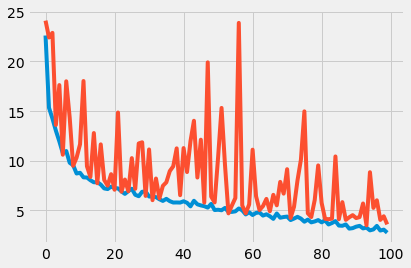

In [83]:
plt.plot(fes_m.losses)
plt.plot(fes_m.val_losses)

In [84]:
trans_losses = fes_m.losses.copy()
trans_val_losses = fes_m.val_losses.copy()


    
    

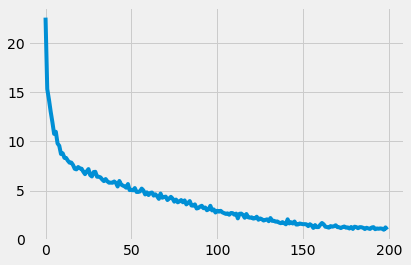